In [1]:
!rm -f ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0


In [3]:
!unzip -q /content/fer2013.zip -d /content/

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import VGG16, ResNet50, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model


<ipython-input-4-ba2e60b43b36>:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
project_name = 'FER_2013_Emotion_Detection'


model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'ResNet50_Transfer_Learning',
    'InceptionResNetV2_Transfer_Learning'
]


base_dir = '/content/'


project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)


for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/FER_2013_Emotion_Detection


**Data Cleaning**

In [6]:
image_exts = ['jpeg','jpg','png']

data_dir = '/content/train'

for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)

    try:

       file_type = imghdr.what(file_path)

       if file_type not in image_exts:
        print(f"Image Not In Exts Lits {file_path}")
        os.remove(file_path)

       else:
        img = cv2.imread(file_path)
    except Exception as E:
      print(f"ISSUE WITH FILE PATH : {file_path}, ERROR : {E}")
      os.remove(file_path)

**Data Analysis**

In [7]:
def Count_file_in_subdir(directory,set_name):
  class_count = {}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)

    if os.path.isdir(item_path):
      class_count[item] = len(os.listdir(item_path))

  df = pd.DataFrame(class_count, index =[set_name])
  return df
train_dir = '/content/train'
test_dir = '/content/test'



train_df = Count_file_in_subdir(train_dir,'Train')
print(train_df)
test_df = Count_file_in_subdir(test_dir,'Test')
print(test_df)


        sad  happy  angry  fear  neutral  disgust  surprise
Train  4830   7215   3995  4097     4965      436      3171
       sad  happy  angry  fear  neutral  disgust  surprise
Test  1247   1774    958  1024     1233      111       831


<Axes: >

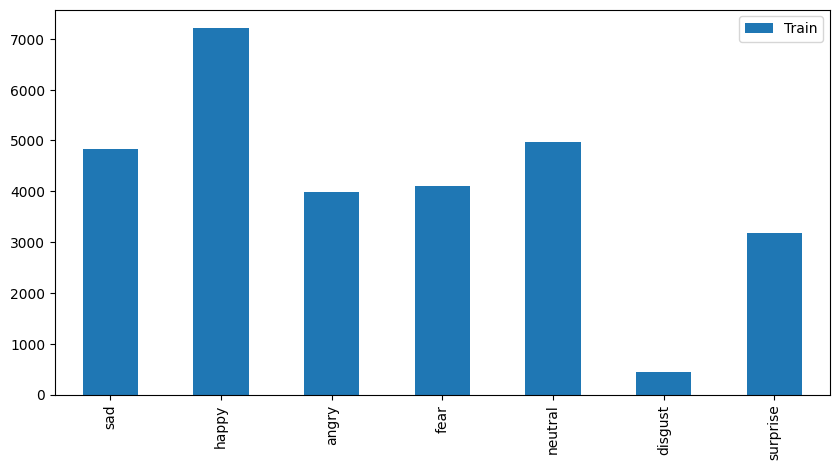

In [8]:
train_df.transpose().plot(kind = 'bar', figsize = (10,5))

<Axes: >

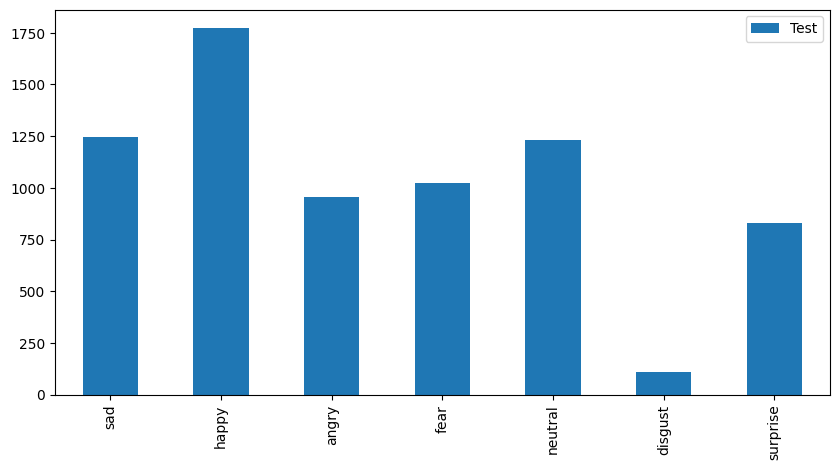

In [9]:
test_df.transpose().plot(kind = 'bar', figsize = (10,5))

**Plotting one image from each emotion.**

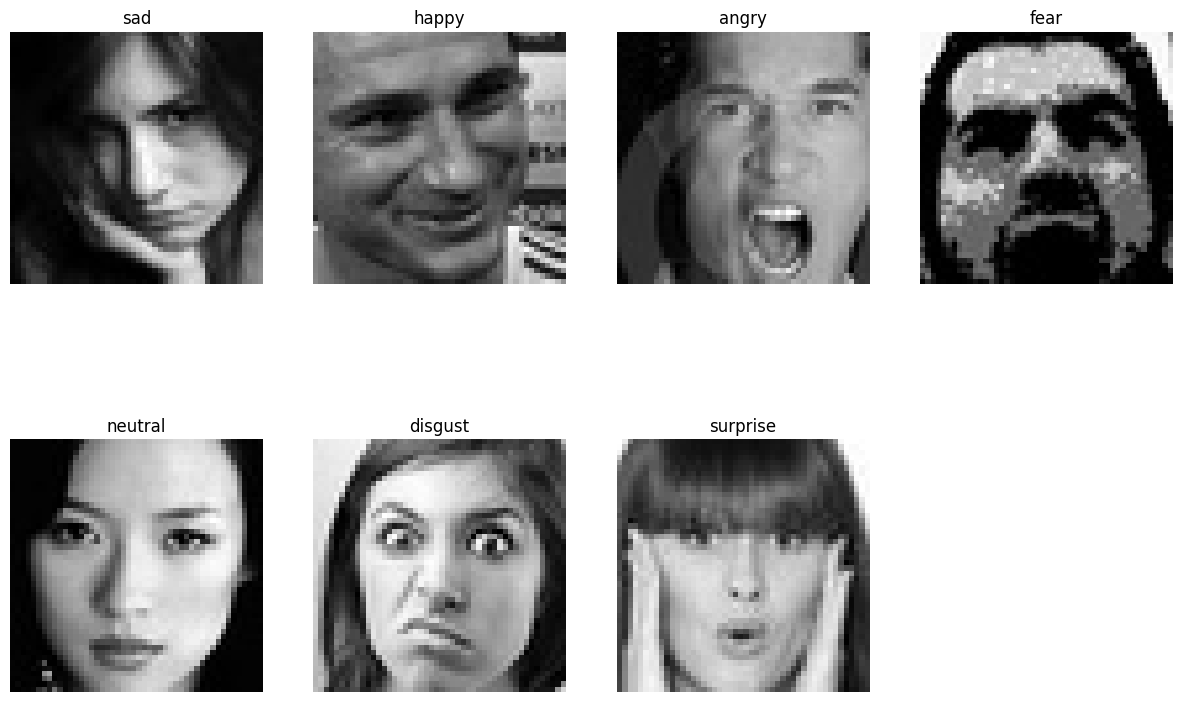

In [10]:
Emotion_dir = os.listdir(train_dir)
plt.figure(figsize = (15,15))

for i,emotion in enumerate(Emotion_dir,1):
  folder = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder,os.listdir(folder)[15])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap = 'gray')
  plt.title(emotion)
  plt.axis('off')

**Plotting random images from given directory**


In [11]:
def plot_images_from_directory(directory_path, class_name, num_images=9):

    image_filenames = os.listdir(directory_path)


    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)


    selected_images = random.sample(image_filenames, num_images)


    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)

        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

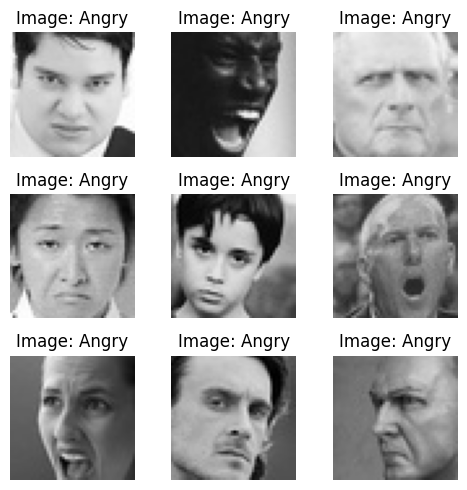

In [12]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

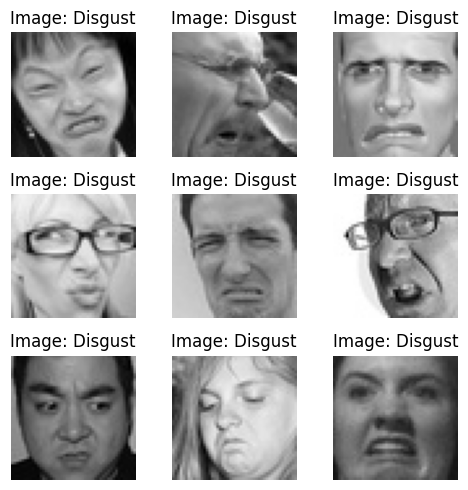

In [13]:
disgust_directory_path = '/content/train/disgust'
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

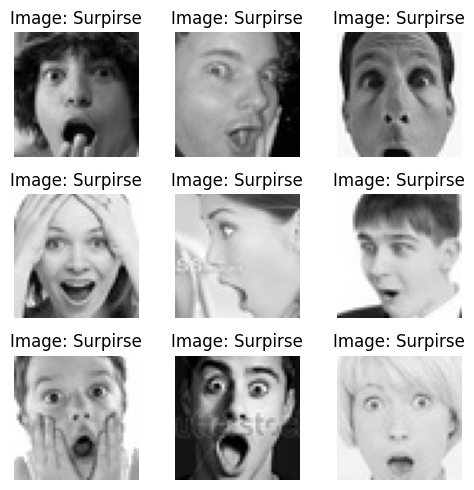

In [14]:
surpirse_directory_path = '/content/train/surprise'
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

**Checking shapes and channels.**

In [15]:
image = '/content/train/happy/Training_10066226.jpg'

img = cv2.imread(image)

if img is not None:
  print(f"Image Shape {img.shape}")
else:
  print("Image could not be loaded")

Image Shape (48, 48, 3)


In [16]:
image = '/content/train/happy/Training_10066226.jpg'

img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)

if img is not None:
  print(f"Image Shape {img.shape}")
else:
  print("Image could not be loaded")

Image Shape (48, 48)


**Model 1 : Custom CNN from Scratch**

In [17]:
train_dir_path = '/content/train'
test_dir_path = '/content/test'

In [18]:
img_height = 48
img_width = 48
batch_size = 64
epoch = 25
num_class = 7



In [19]:
datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)

train_gen = datagen.flow_from_directory(train_dir_path,
                                        target_size = (img_height,img_width),
                                        batch_size = batch_size,
                                        color_mode = 'grayscale',
                                        class_mode = 'categorical',
                                        subset = 'training'
)


val_gen = datagen.flow_from_directory(train_dir_path,
                                        target_size = (img_height,img_width),
                                        batch_size = batch_size,
                                        color_mode = 'grayscale',
                                        class_mode = 'categorical',
                                        subset = 'validation'
)


test_gen = datagen.flow_from_directory(test_dir_path,
                                        target_size = (img_height,img_width),
                                        batch_size = batch_size,
                                        color_mode = 'grayscale',
                                        class_mode = 'categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
train_class_labels = train_gen.class_indices
print(f"Train Class Labels : {train_class_labels}")

val_class_labels = val_gen.class_indices
print(f"Validation Class Labels : {val_class_labels}")

test_class_labels = test_gen.class_indices
print(f"Train Class Labels : {test_class_labels}")

Train Class Labels : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation Class Labels : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Train Class Labels : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [21]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.30))


model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.30))

model.add(Conv2D(512,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(num_class))
model.add(Activation('softmax'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,662,023 (33.04 MB)

 Trainable params: 8,658,311 (33.03 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,662,023 (33.04 MB)

 Trainable params: 8,658,311 (33.03 MB)

 Non-trainable params: 3,712 (14.50 KB)

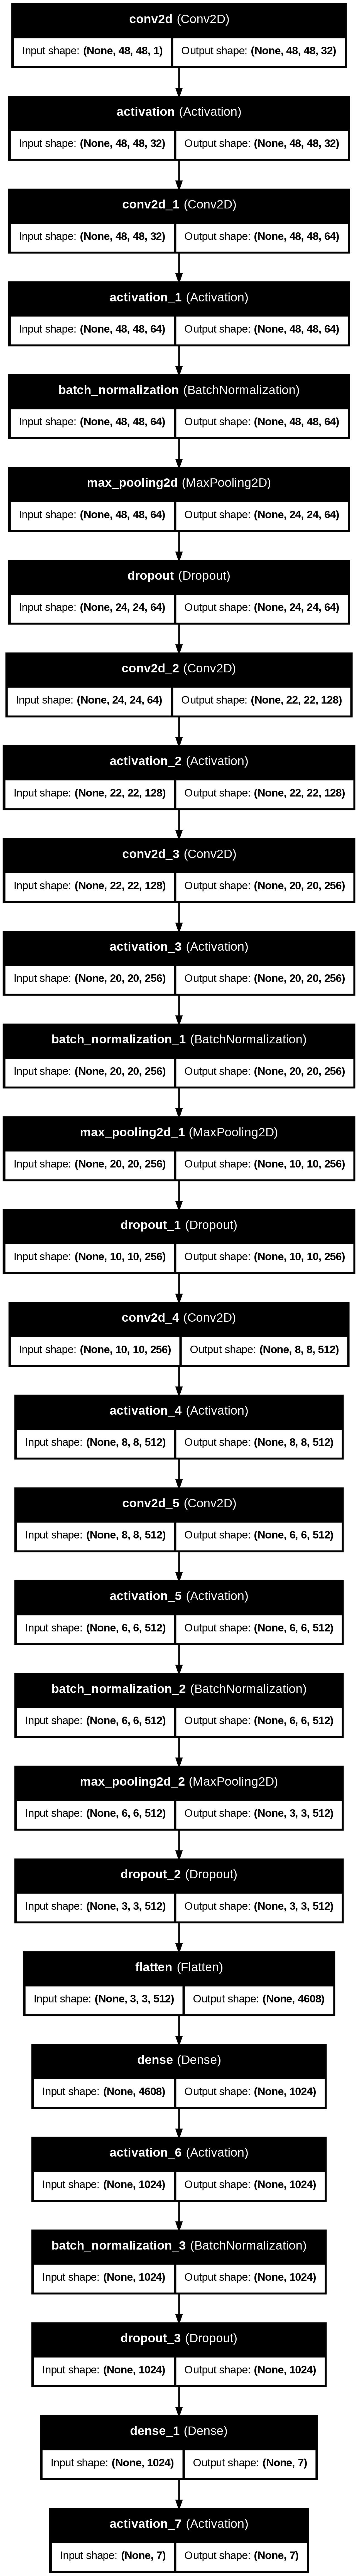

In [25]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [26]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [27]:
from re import VERBOSE
checkpoint = ModelCheckpoint(filepath=chk_path,
                             monitor = "val_loss",
                             save_best_only = True,
                             verbose = 1,
                             mode ='min')

In [28]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [30]:
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [31]:
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

**Calculating Steps for epoch**

In [32]:
train_gen.samples

22968

In [33]:
train_steps_per_epoch = train_gen.samples // train_gen.batch_size + 1
validation_steps_epoch = val_gen.samples // val_gen.batch_size + 1
test_steps_epoch = test_gen.samples // test_gen.batch_size + 1

In [34]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epoch,
    validation_data=val_gen,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2223 - loss: 13.2096
Epoch 1: val_loss improved from inf to 12.37887, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.2224 - loss: 13.2080 - val_accuracy: 0.2513 - val_loss: 12.3789 - learning_rate: 1.0000e-04
Epoch 2/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3240 - loss: 11.1267
Epoch 2: val_loss improved from 12.37887 to 9.64557, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.3240 - loss: 11.1254 - val_accuracy: 0.3522 - val_loss: 9.6456 - learning_rate: 1.0000e-04
Epoch 3/25
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3709 - loss: 9.2372
Epoch 3: val_loss improved from 9.64557 to 7.83864, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras


**Plotting Performance Metrics**

In [35]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


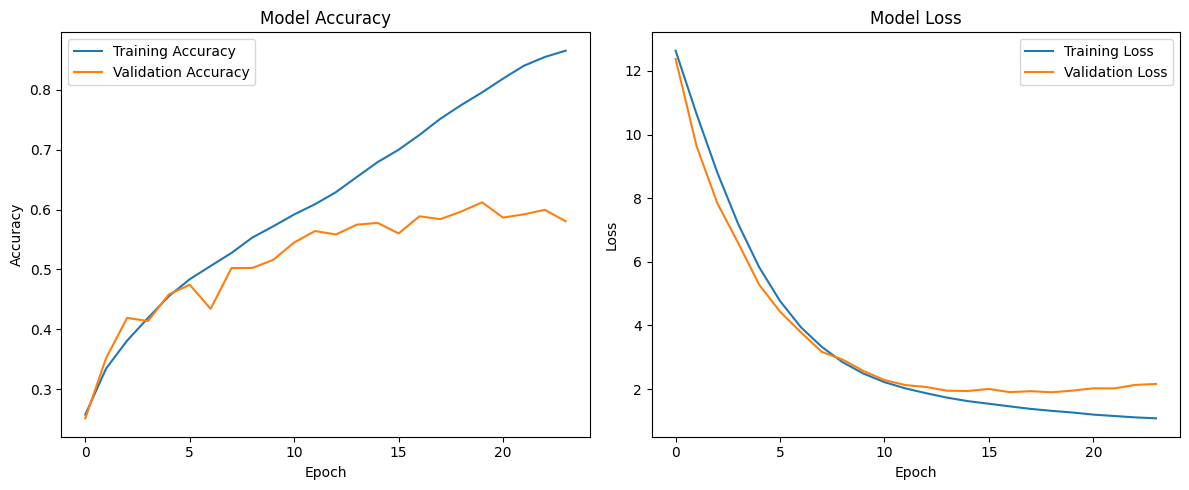

In [36]:
plot_training_history(history)

**Model Evaluation**

In [37]:
train_loss, train_acc = model.evaluate(train_gen)
test_loss,test_acc = model.evaluate(test_gen)

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9110 - loss: 1.0216
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6061 - loss: 1.8805
final train accuracy = 90.82 , validation accuracy = 60.34


**Plotting Confusion Matrix**

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


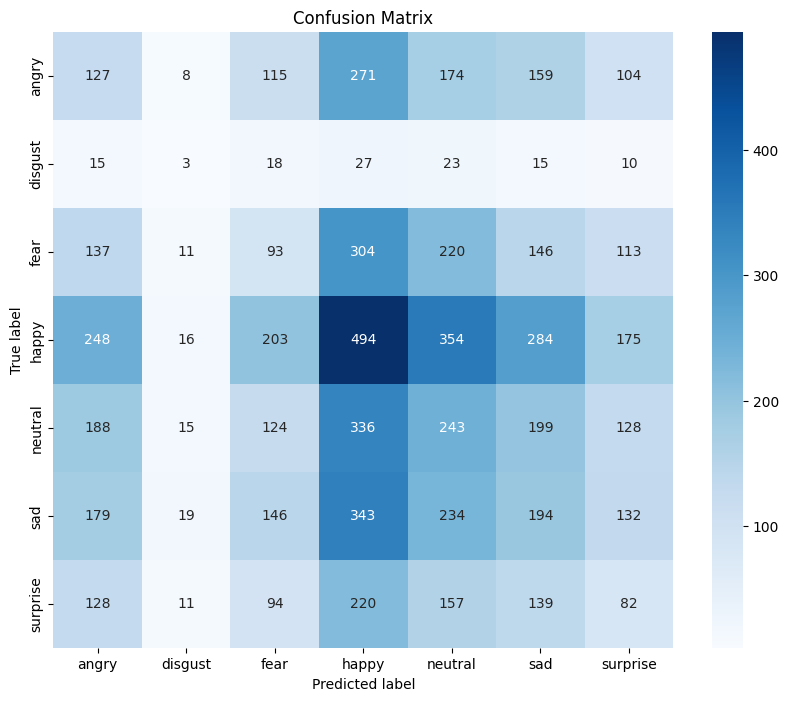

In [38]:
true_classes = test_gen.classes
predicted_classes = np.argmax(model.predict(test_gen, steps=int(np.ceil(test_gen.samples/test_gen.batch_size))), axis=1)
class_labels = list(test_gen.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [39]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.13      0.13       958
     disgust       0.04      0.03      0.03       111
        fear       0.12      0.09      0.10      1024
       happy       0.25      0.28      0.26      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.17      0.16      0.16      1247
    surprise       0.11      0.10      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



**Making Predictions**

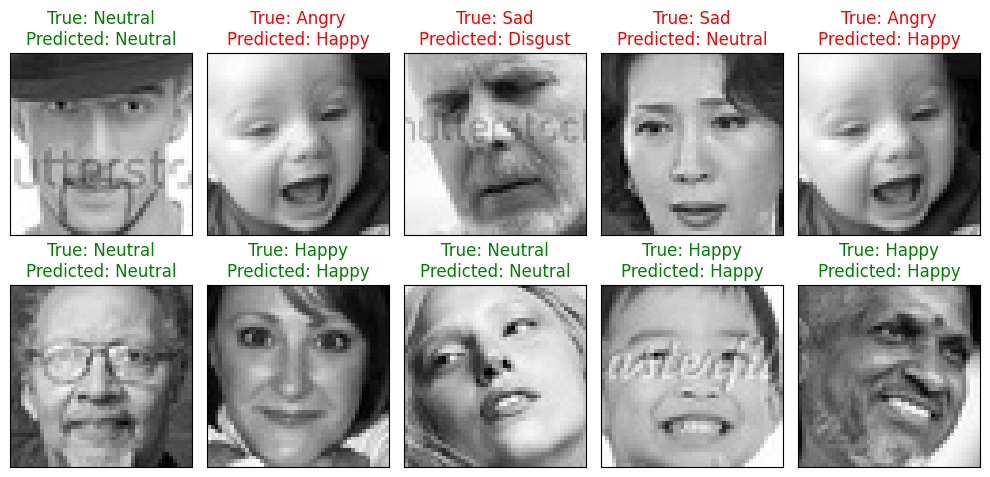

In [40]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_gen.batch_size

Random_batch = np.random.randint(0,len(test_gen)-1)

Random_img_index = np.random.randint(0,batch_size,10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i,ax in enumerate(axes.flat):
  Random_Img = test_gen[Random_batch][0][Random_img_index[i]]
  Random_Img_Label = np.argmax(test_gen[Random_batch][1][Random_img_index[i]], axis=0)


  Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

  ax.imshow(Random_Img.squeeze(), cmap='gray')

  color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
  ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

**Model 2: Image Augmentation**

In [41]:
print(train_dir_path)
print(test_dir_path)

/content/train
/content/test


In [42]:

img_width = 48
img_height = 48
batch_size = 64
epoch = 10
num_class = 7

data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip =True,
    fill_mode = 'nearest',
    validation_split = 0.2
)


test_data_generator = ImageDataGenerator(rescale=1./255)


train_generator = data_gen.flow_from_directory(
    train_dir_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_gen.flow_from_directory(
    train_dir_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_dir_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


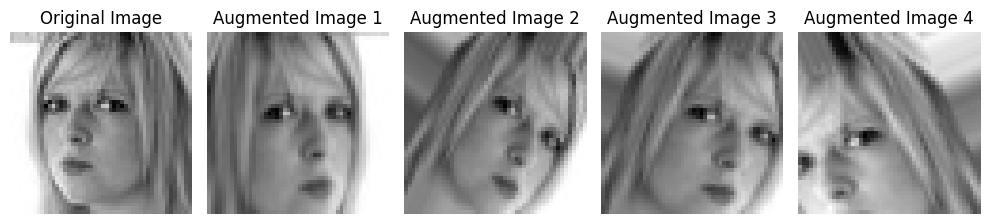

In [43]:
image_path = '/content/train/angry/Training_10316849.jpg'


img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))

axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


for i, ax in enumerate(axes.flat[1:]):

    aug_iter = data_gen.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]


    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Same CNN Model as above**

In [44]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
#model.add(Dropout(0.30))


model.add(Conv2D(128,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
#model.add(Dropout(0.30))

model.add(Conv2D(512,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),kernel_regularizer= regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
#model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.20))

model.add(Dense(num_class))
model.add(Activation('softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

In [47]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             monitor = "val_loss",
                             save_best_only = True,
                             verbose = 1,
                             mode ='min')

In [48]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

In [49]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


In [50]:
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [51]:
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [52]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [53]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2061 - loss: 12.9604
Epoch 1: val_loss improved from inf to 11.13549, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.2061 - loss: 12.9584 - val_accuracy: 0.2176 - val_loss: 11.1355 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2671 - loss: 10.3050
Epoch 2: val_loss improved from 11.13549 to 8.46671, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.2671 - loss: 10.3032 - val_accuracy: 0.2623 - val_loss: 8.4667 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2948 - loss: 7.8600
Epoch 3: val_loss improved from 8.46671 to 6.51734, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_A

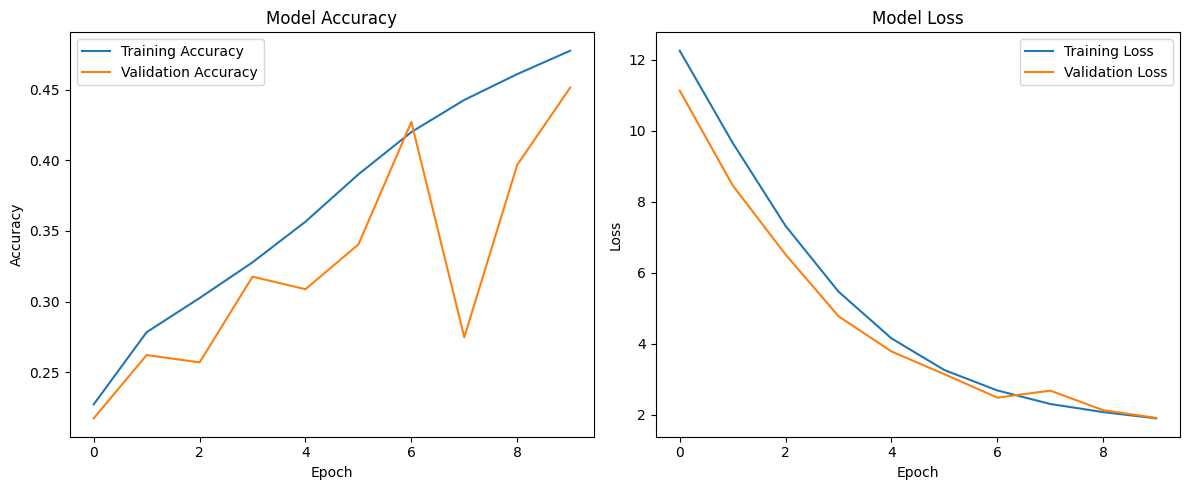

In [54]:
plot_training_history(history)

In [55]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4583 - loss: 1.8891
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5072 - loss: 1.7509
final train accuracy = 45.16 , validation accuracy = 51.07


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


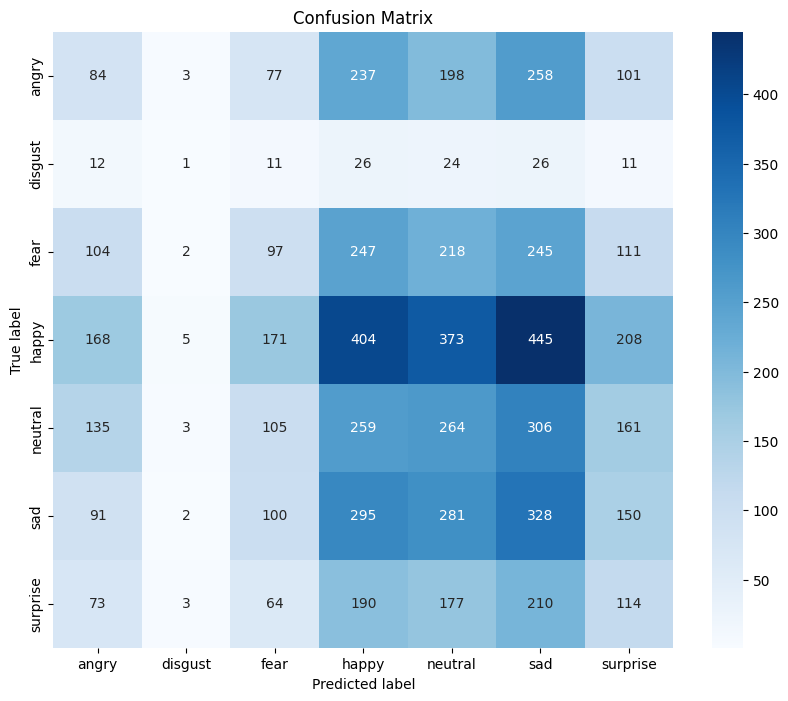

In [56]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [57]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.09      0.10       958
     disgust       0.05      0.01      0.02       111
        fear       0.16      0.09      0.12      1024
       happy       0.24      0.23      0.24      1774
     neutral       0.17      0.21      0.19      1233
         sad       0.18      0.26      0.21      1247
    surprise       0.13      0.14      0.14       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.17      7178



**Transfer Leanring - ResNet50**

In [58]:

train_dir = '/content/train'
test_dir = '/content/test'


batch_size = 64


train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,
                                  rotation_range=10,
                                  zoom_range=0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                 )


test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.
                                 )


train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    class_mode="categorical",
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    subset='training'
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  class_mode="categorical",
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  batch_size=batch_size
                                                 )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Class wieghts for imbalanced data**

In [59]:

classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)


class_weights_dict = dict(enumerate(class_weights))


print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [60]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [61]:

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [62]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [63]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')


earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1)


csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))


callbacks = [checkpoint, earlystop, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1

test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [66]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=20,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.3016 - loss: 1.9559
Epoch 1: val_loss improved from inf to 1.67581, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 459s 942ms/step - accuracy: 0.3017 - loss: 1.9555 - val_accuracy: 0.4519 - val_loss: 1.6758
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.4602 - loss: 1.4285
Epoch 2: val_loss improved from 1.67581 to 1.41970, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 431s 835ms/step - accuracy: 0.4602 - loss: 1.4284 - val_accuracy: 0.5549 - val_loss: 1.4197
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.5246 - loss: 1.2754
Epoch 3: val_loss improved from 1.41970 to 1.18512, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/44

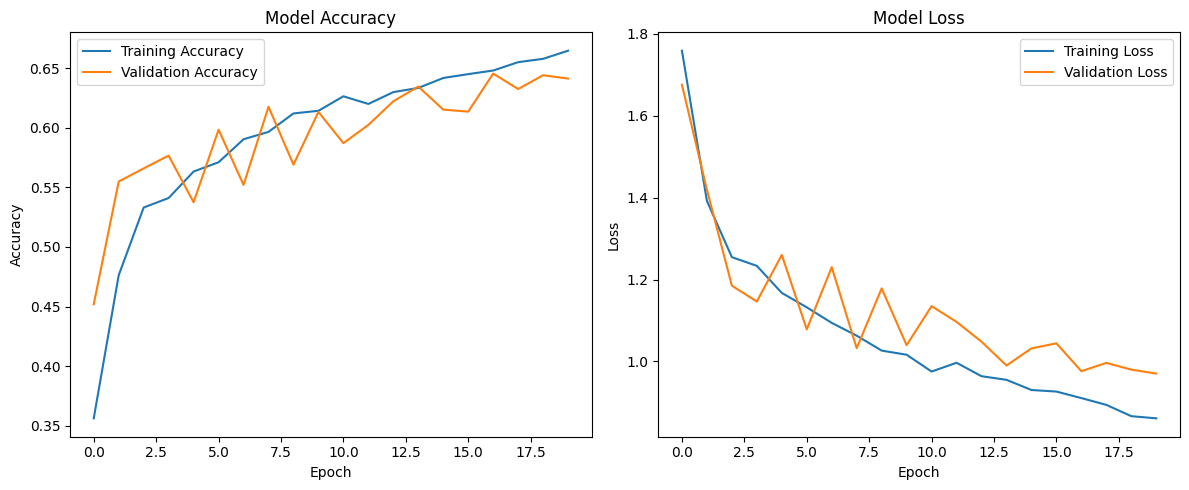

In [67]:
plot_training_history(train_history)

In [68]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 340s 757ms/step - accuracy: 0.6699 - loss: 0.8776
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.6022 - loss: 1.0500
final train accuracy = 67.40 , validation accuracy = 64.54


113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 176ms/step


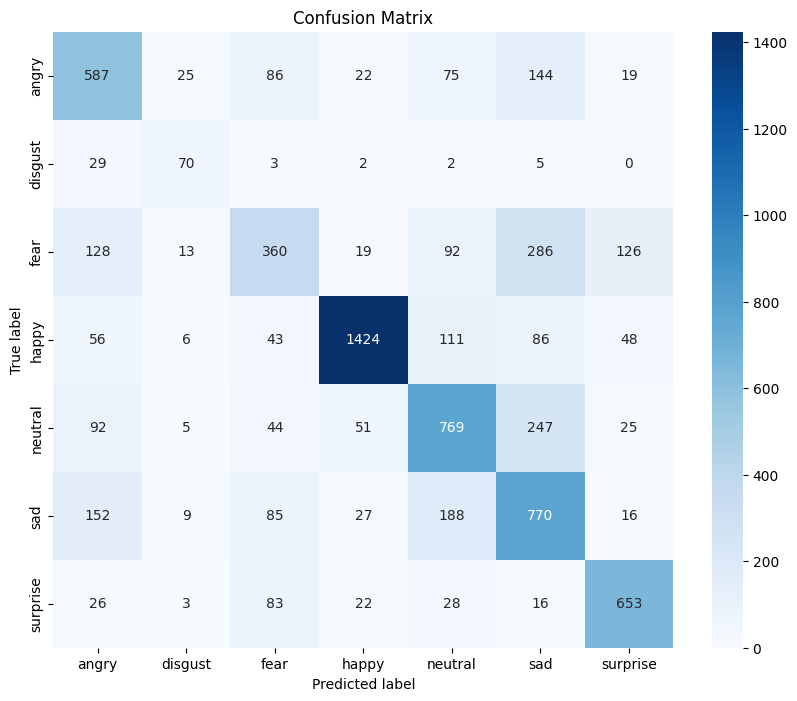

In [70]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [71]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.61      0.58       958
     disgust       0.53      0.63      0.58       111
        fear       0.51      0.35      0.42      1024
       happy       0.91      0.80      0.85      1774
     neutral       0.61      0.62      0.62      1233
         sad       0.50      0.62      0.55      1247
    surprise       0.74      0.79      0.76       831

    accuracy                           0.65      7178
   macro avg       0.62      0.63      0.62      7178
weighted avg       0.65      0.65      0.65      7178

